In [1]:
!pip install tensorflow keras pandas scikit-learn obspy PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.1 MB/s eta 0:00:00
  Attempting uninstall: sqlalchemy
    Found existing installation: SQLAlchemy 2.0.35
    Uninstalling SQLAlchemy-2.0.35:
      Successfully uninstalled SQLAlchemy-2.0.35
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython-sql 0.5.0 requires sqlalchemy>=2.0, but you have sqlalchemy 1.4.54 which is incompatible.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

drive_data_directory = '/content/drive/My Drive/shakeitoff/'
local_data_directory = '/content/data_directory/'
if not os.path.exists(local_data_directory):
    os.makedirs(local_data_directory)
    print(f"Pasta {local_data_directory} criada.")
else:
    print(f"Pasta {local_data_directory} já existe.")


!cp -r "{drive_data_directory}" "{local_data_directory}"

Pasta /content/data_directory/ criada.


In [3]:
import os
import numpy as np
import pandas as pd
from obspy import read

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from pprint import pprint


basePath = '/content/data_directory/shakeitoff'
data_directory = basePath + '/data/lunar/training/data/S12_GradeA/'
catalog_file = basePath + '/data/lunar/training/catalogs/apollo12_catalog_GradeA_updated.csv'
catalog_df = pd.read_csv(catalog_file)

# Parse 'time_abs' as datetime
catalog_df['time_abs'] = pd.to_datetime(catalog_df['time_abs'])
catalog_df['filename_base'] = catalog_df['filename'].str.split('_evid').str[0]


pprint(catalog_df['time_abs'])
pprint(catalog_df['filename_base'])




0    1970-01-19 20:25:00
1    1970-03-25 03:32:00
2    1970-03-26 20:17:00
3    1970-04-25 01:14:00
4    1970-04-26 14:29:00
             ...        
73   1975-05-04 10:05:00
74   1975-06-24 16:03:00
75   1975-06-26 03:24:00
76   1971-09-25 11:40:00
77   1972-12-02 21:42:00
Name: time_abs, Length: 78, dtype: datetime64[ns]
0     xa.s12.00.mhz.1970-01-19HR00
1     xa.s12.00.mhz.1970-03-25HR00
2     xa.s12.00.mhz.1970-03-26HR00
3     xa.s12.00.mhz.1970-04-25HR00
4     xa.s12.00.mhz.1970-04-26HR00
                  ...             
73    xa.s12.00.mhz.1975-05-04HR00
74    xa.s12.00.mhz.1975-06-24HR00
75    xa.s12.00.mhz.1975-06-26HR00
76    xa.s12.00.mhz.1971-09-25HR00
77    xa.s12.00.mhz.1972-12-02HR00
Name: filename_base, Length: 78, dtype: object


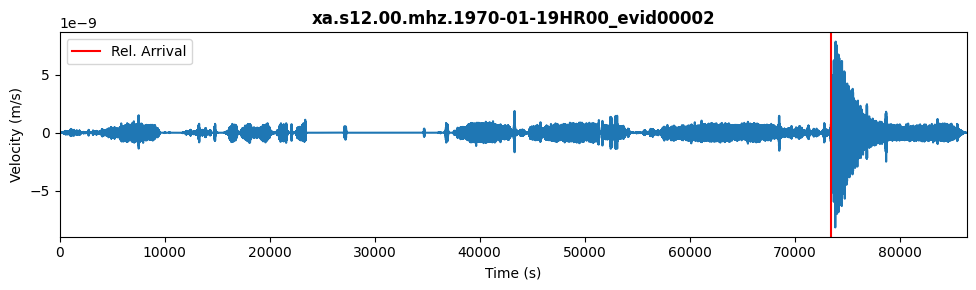

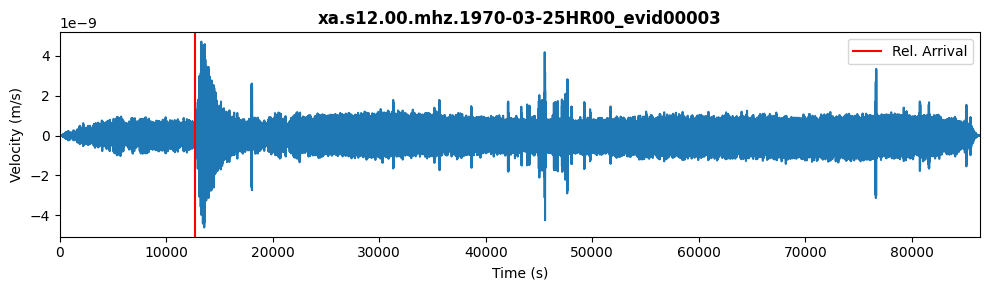

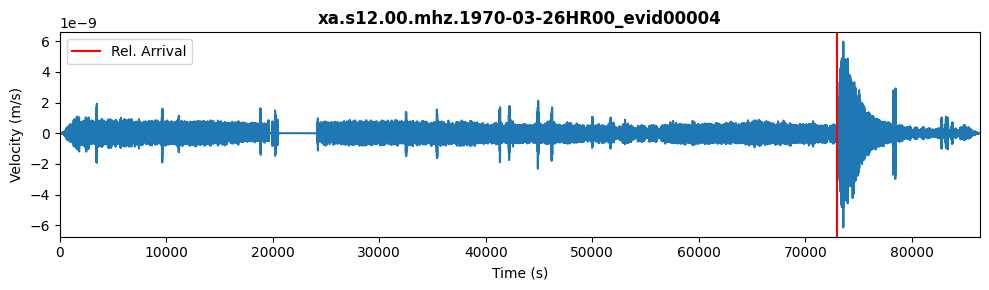

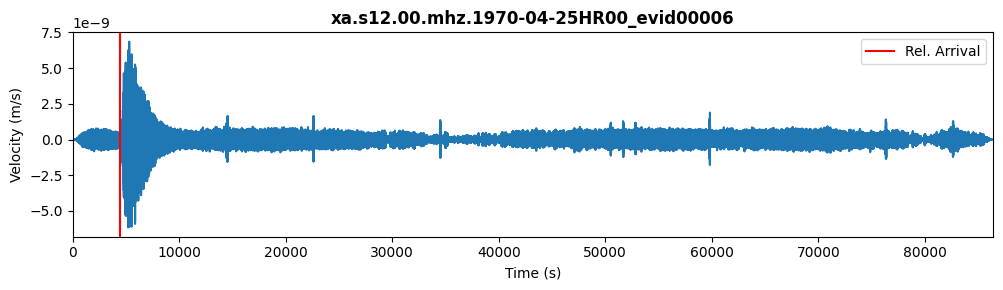

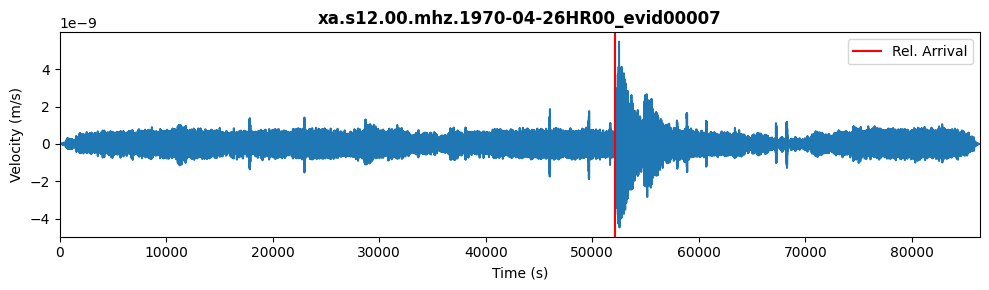

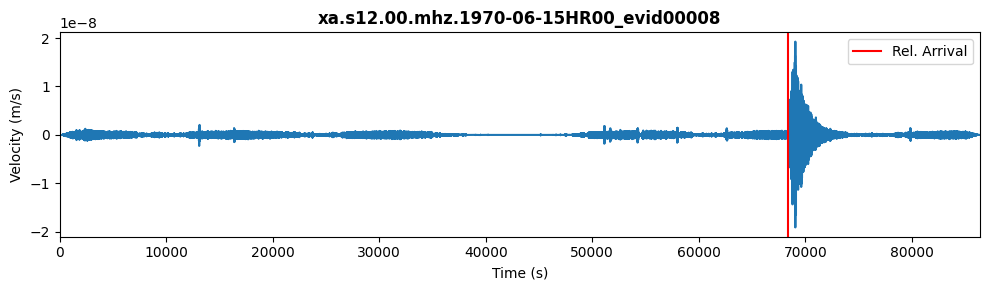

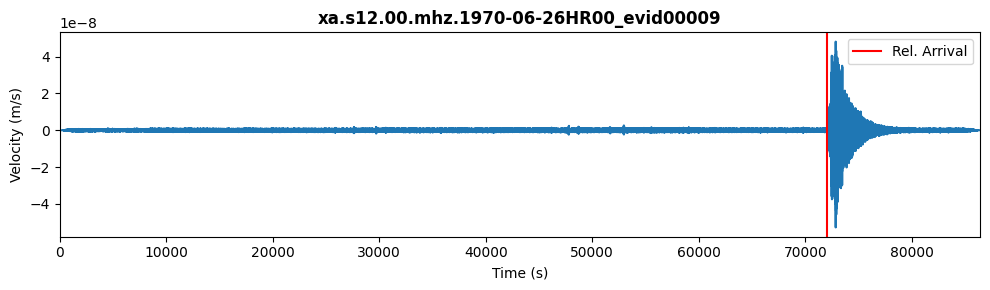

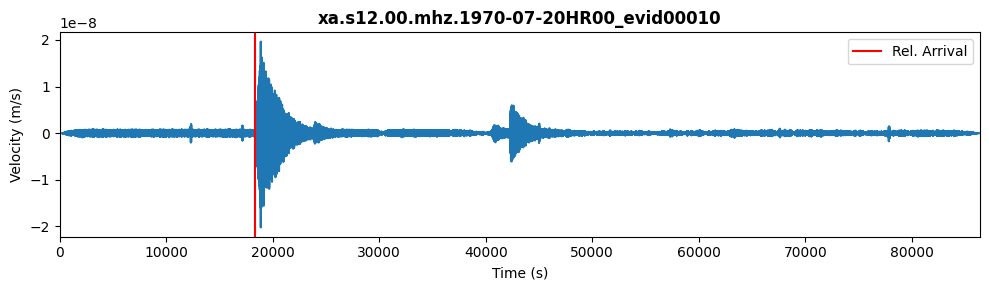

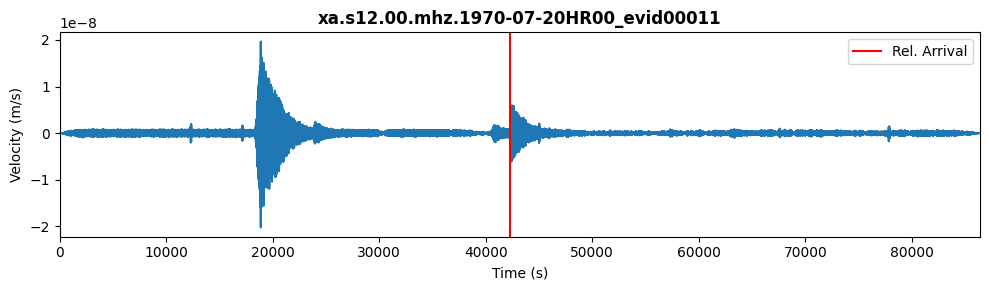

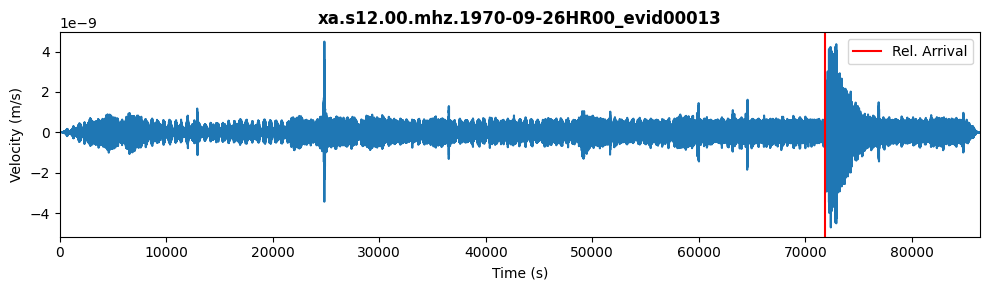

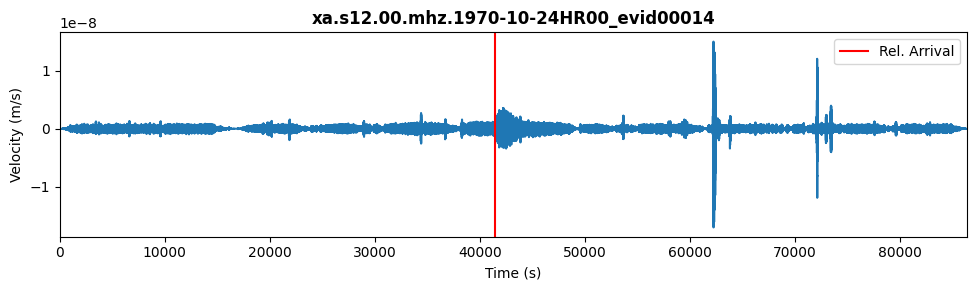

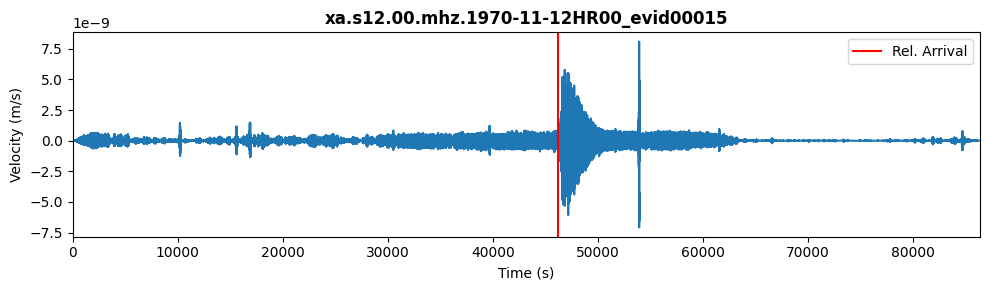

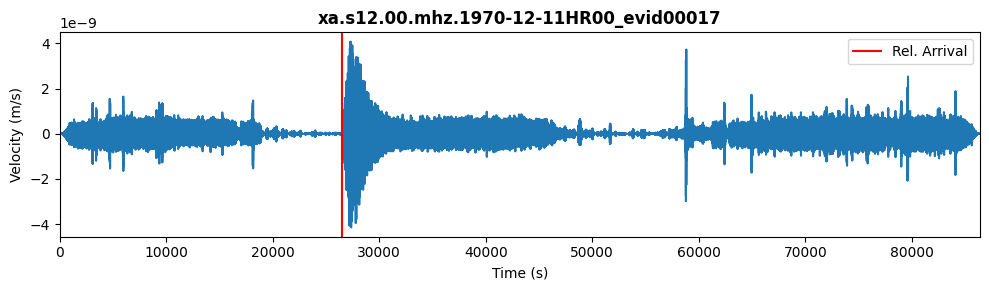

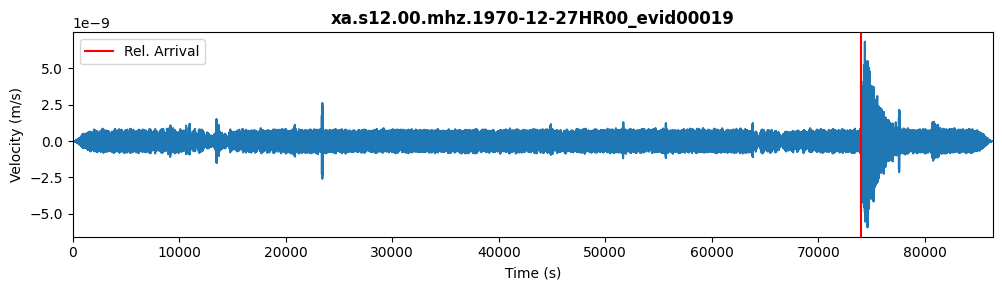

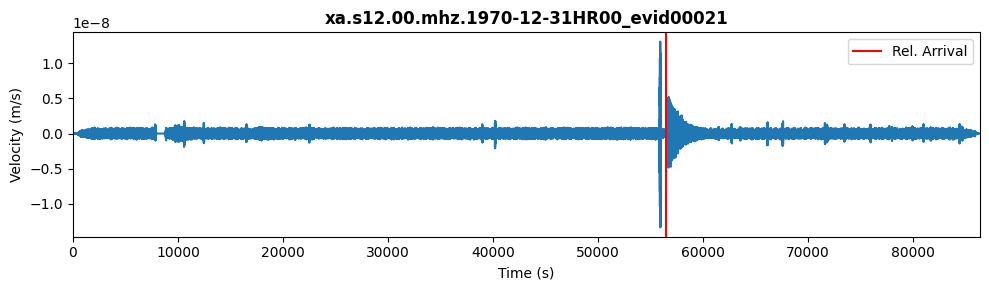

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [4]:
### BASIC VISUALIZATION, ONLY PLOT THE TRAINING SISMICS WITH CATALOG LINE, WITHOUT ANY TREATMEANTS

import matplotlib.pyplot as plt
from datetime import datetime
for index, row in catalog_df.iterrows():
    test_filename = row['filename']
    csv_file = f'{data_directory}{test_filename}.csv'

    if not os.path.exists(csv_file):
        print(f"Arquivo {csv_file} não encontrado, pulando para o próximo.")
        continue

    data_cat = pd.read_csv(csv_file)

    csv_times = np.array(data_cat['time_rel(sec)'].tolist())
    csv_data = np.array(data_cat['velocity(m/s)'].tolist())

    arrival_time = row['time_abs']
    arrival_time_rel = row['time_rel(sec)']

    fig, ax = plt.subplots(1, 1, figsize=(10, 3))
    ax.plot(csv_times, csv_data)

    ax.set_xlim([min(csv_times), max(csv_times)])
    ax.set_ylabel('Velocity (m/s)')
    ax.set_xlabel('Time (s)')
    ax.set_title(f'{test_filename}', fontweight='bold')

    arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
    ax.legend(handles=[arrival_line])

    plt.tight_layout()
    plt.show()

In [5]:
# BASIC PLOT FUNCTION THAT SUPORT GROUPED ARRIVALS
from scipy.signal import butter, filtfilt
import matplotlib.pyplot as plt
from scipy import interpolate


def plot_sismogram(times, original_data, processed_data, filename, arrival_times_rel):
    """
    Plots the sismogram before and after processing, supporting multiple arrival times.
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(times, original_data, color='blue')
    ax1.set_xlim([min(times), max(times)])
    ax1.set_ylabel('Velocity (m/s)')
    ax1.set_xlabel('Time (s)')
    ax1.set_title(f'{filename} - Original', fontweight='bold')

    for i, arrival_time in enumerate(arrival_times_rel):
        if i == 0:
            ax1.axvline(x=arrival_time, c='red', linestyle='--', label='Rel. Arrival')
        else:
            ax1.axvline(x=arrival_time, c='red', linestyle='--')

    ax1.legend()

    ax2.plot(times, processed_data, color='green')
    ax2.set_xlim([min(times), max(times)])
    ax2.set_ylabel('Velocity (m/s)')
    ax2.set_xlabel('Time (s)')
    ax2.set_title(f'{filename} - Processed', fontweight='bold')

    for i, arrival_time in enumerate(arrival_times_rel):
        if i == 0:
            ax2.axvline(x=arrival_time, c='red', linestyle='--', label='Rel. Arrival')
        else:
            ax2.axvline(x=arrival_time, c='red', linestyle='--')

    ax2.legend()

    plt.tight_layout()
    plt.show()



In [7]:
### FUNCTIONS TO PROCESS SIGNAL

import pywt
def icwt(coefficients, scales, wavelet, dt):

    C_psi = pywt.central_frequency(wavelet) * np.sqrt(2 * np.pi)

    reconstructed_signal = np.zeros(coefficients.shape[1])
    for i, scale in enumerate(scales):
        reconstructed_signal += np.real(coefficients[i, :]) / (scale**0.5)

    reconstructed_signal *= C_psi * 1 / len(scales)
    return reconstructed_signal

from itertools import groupby
from operator import itemgetter

def find_consecutive_segments(indices, max_gap=1):
    segments = []
    current_segment = [indices[0]]

    for i in range(1, len(indices)):
        gap = indices[i] - indices[i - 1]

        if gap > max_gap:
            segments.append(current_segment)
            current_segment = [indices[i]]
        else:
            current_segment.append(indices[i])

    if current_segment:
        segments.append(current_segment)

    return segments

In [8]:
# COMPLETE FUNCTION TO PLOT SISMOGRAM WITHOUT

import matplotlib.pyplot as plt
from scipy import signal
from matplotlib import cm
def plot_complete_sismogram(times, original_data, processed_data, filename, arrival_time_rel, tr_data_filt, tr_filt, tr_times_filt):
    """
    Plota o sismograma antes e depois do processamento, juntamente com seus espectrogramas.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    ax1 = axes[0, 0]
    ax1.plot(times, original_data, color='blue')
    ax1.set_xlim([min(times), max(times)])
    ax1.set_ylabel('Velocidade (m/s)')
    ax1.set_xlabel('Tempo (s)')
    ax1.set_title(f'{filename} - Original', fontweight='bold')
    ax1.axvline(x=arrival_time_rel, c='red', label='Chegada Relativa')
    ax1.legend()

    ax2 = axes[1, 0]
    ax2.plot(times, processed_data, color='green')
    ax2.set_xlim([min(times), max(times)])
    ax2.set_ylabel('Velocidade (m/s)')
    ax2.set_xlabel('Tempo (s)')
    ax2.set_title(f'{filename} - Processado', fontweight='bold')
    ax2.axvline(x=arrival_time_rel, c='red', label='Chegada Relativa')
    ax2.legend()

    ax3 = axes[0, 1]
    f_orig, t_orig, sxx_orig = signal.spectrogram(original_data, tr_filt.stats.sampling_rate)
    vals_orig = ax3.pcolormesh(t_orig, f_orig, sxx_orig, cmap=cm.jet, shading='auto')
    ax3.set_xlim([min(times), max(times)])
    ax3.set_xlabel('Tempo (s)')
    ax3.set_ylabel('Frequência (Hz)')
    ax3.set_title(f'{filename} - Espectrograma Original', fontweight='bold')
    ax3.axvline(x=arrival_time_rel, c='red', label='Chegada Relativa')
    cbar_orig = plt.colorbar(vals_orig, ax=ax3, orientation='horizontal')
    cbar_orig.set_label('Potência ((m/s)^2/sqrt(Hz))', fontweight='bold')

    ax4 = axes[1, 1]
    f_proc, t_proc, sxx_proc = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
    vals_proc = ax4.pcolormesh(t_proc, f_proc, sxx_proc, cmap=cm.jet, shading='auto')
    ax4.set_xlim([min(tr_times_filt), max(tr_times_filt)])
    ax4.set_xlabel('Tempo (s)')
    ax4.set_ylabel('Frequência (Hz)')
    ax4.set_title(f'{filename} - Espectrograma Processado', fontweight='bold')
    ax4.axvline(x=arrival_time_rel, c='red', label='Chegada Relativa')
    cbar_proc = plt.colorbar(vals_proc, ax=ax4, orientation='horizontal')
    cbar_proc.set_label('Potência ((m/s)^2/sqrt(Hz))', fontweight='bold')

    plt.tight_layout()
    plt.show()


In [9]:
import numpy as np
from obspy import read
import pywt
from scipy.interpolate import interp1d

# PROCESSING SIGNAL FUNCTION

def signal_processing(mseed_file):
    # Definindo frequências de filtro e diretório de dados
    minfreq = 0.6
    maxfreq = 1

    # Leitura do arquivo miniseed
    st = read(mseed_file)
    tr = st[0]
    sampling_rate = tr.stats.sampling_rate
    frequencies = np.linspace(minfreq, maxfreq, num=100)  # Ajuste 'num' conforme necessário

    wavelet = pywt.ContinuousWavelet('cmor2-1.0')  # Morlet wavelet
    scales = pywt.scale2frequency(wavelet, frequencies) * sampling_rate
    tr_times = tr.times()
    tr_data = tr.data

    # Filtro de bandpass
    st_filt = st.copy()
    st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq, corners=4)
    filtered_data = st_filt.traces[0].data

    ###### FOR SOME REASON, IF WE APPLY THE FILTERS BELOW, THE MODEL DOESN'T CONVERGE CORRECTLY


    # # CWT no sinal
    # coefficients, frequencies = pywt.cwt(filtered_data, scales, wavelet, sampling_period=1/sampling_rate)

    # # Definir um limite de thresholding (limiar) para remover ruídos de baixa magnitude
    # threshold = np.percentile(np.abs(coefficients), 95)  # Ajuste o valor do threshold de acordo com seu sinal

    # # Aplicar o threshold nos coeficientes
    # coefficients_filtered = pywt.threshold(coefficients, threshold, mode='soft')

    # # Aplicar o modelo de icwt para reconstruir o sinal
    # reconstructed_signal = icwt(coefficients_filtered, scales, wavelet, 1/sampling_rate)

    reconstructed_signal = filtered_data

    # # Definir um limite baseado no percentil 99 do sinal reconstruído
    # percentil_99 = np.percentile(np.abs(reconstructed_signal), 99)

    # # Identificar picos que excedem o limite
    # outliers_indices = np.where(np.abs(reconstructed_signal) > percentil_99)[0]

    # # Agrupar índices consecutivos
    # segments = find_consecutive_segments(outliers_indices, 200)

    # # Definir um limite máximo de duração para picos (em número de amostras)
    # max_spike_duration = 1000

    # for segment in segments:
    #     duration = len(segment)
    #     if duration <= max_spike_duration:
    #         # Substituir o segmento por valores interpolados
    #         if segment[0] > 0 and segment[-1] < len(reconstructed_signal) - 1:
    #             x = [segment[0] - 1, segment[-1] + 1]
    #             y = [reconstructed_signal[segment[0] - 1], reconstructed_signal[segment[-1] + 1]]
    #             f = interp1d(x, y, kind='linear')
    #             reconstructed_signal[segment[0]:segment[-1] + 1] = f(np.arange(segment[0], segment[-1] + 1))

    # Obter dados para visualização
    # tr_filt = st_filt.traces[0].copy()
    # tr_times_filt = tr_filt.times()
    # tr_data_filt = tr_filt.data
    # arrival_time = row['time_abs']
    # arrival_time_rel = row['time_rel(sec)']


    #print(f"Original signal shape: {tr_data.shape}")
    #print(f"Reconstructed signal shape: {reconstructed_signal.shape}")
    #Plotar o sismograma completo
    #plot_complete_sismogram(tr_times, tr_data, reconstructed_signal, mseed_file, arrival_time_rel, tr_data_filt, tr_filt, tr_times_filt)

    return reconstructed_signal

In [10]:

##### PROCESSAMENTO  DOS SISMOGRAMAS


arr_desired_files = [
      "xa.s12.00.mhz.1970-10-24HR00_evid00014.csv",
      "xa.s12.00.mhz.1970-12-31HR00_evid00021.csv"
      "xa.s12.00.mhz.1971-01-28HR00_evid00023.csv",
      "xa.s12.00.mhz.1971-01-29HR00_evid00024.csv",
      "xa.s12.00.mhz.1971-10-18HR00_evid00043.csv",
      "xa.s12.00.mhz.1971-10-20HR00_evid00044.csv",
      "xa.s12.00.mhz.1972-01-04HR00_evid00049.csv",
      "xa.s12.00.mhz.1972-05-11HR00_evid00055.csv",
      "xa.s12.00.mhz.1974-06-25HR00_evid00149.csv",
      "xa.s12.00.mhz.1974-07-06HR00_evid00150.csv",

      # especial (zerado)
      "xa.s12.00.mhz.1972-12-03HR00_evid00084.csv",
      "xa.s12.00.mhz.1973-01-18HR00_evid00088.csv",
    ]

all_filtered_sis = []

unique_filename_bases = catalog_df['filename_base'].unique()

print(unique_filename_bases)

for filename_base in unique_filename_bases:
    df_day = catalog_df[catalog_df['filename_base'] == filename_base]

    if df_day.empty:
        print(f"No data found for {filename_base}. Skipping to the next one.")
        continue

    test_filename = df_day.iloc[0]['filename']

    print(test_filename)
    mseed_file = f'{data_directory}{test_filename}.mseed'
    csv_file = f'{test_filename}.csv'

    filenameWithoutEvid = test_filename.split('_evid')[0]

    if not os.path.exists(mseed_file):
        print(f"File {mseed_file} not found. Skipping to the next one.")
        continue

    st = read(mseed_file)
    tr = st[0]

    filtered_data = signal_processing(mseed_file=mseed_file)

    trace_start_time = tr.stats.starttime
    df_sampling_rate = tr.stats.sampling_rate
    n_samples = len(filtered_data)

    arrival_times_abs = df_day['time_abs'].tolist()
    arrival_times_rel = df_day['time_rel(sec)'].tolist()

    filtered_sis_info = {
        'data': filtered_data,
        'start_time': trace_start_time,
        'sampling_rate': df_sampling_rate,
        'n_samples': n_samples,
        'filename_base': filename_base,
        'arrival_times_abs': arrival_times_abs,
        'arrival_times_rel': arrival_times_rel,
    }

    all_filtered_sis.append(filtered_sis_info)


['xa.s12.00.mhz.1970-01-19HR00' 'xa.s12.00.mhz.1970-03-25HR00'
 'xa.s12.00.mhz.1970-03-26HR00' 'xa.s12.00.mhz.1970-04-25HR00'
 'xa.s12.00.mhz.1970-04-26HR00' 'xa.s12.00.mhz.1970-06-15HR00'
 'xa.s12.00.mhz.1970-06-26HR00' 'xa.s12.00.mhz.1970-07-20HR00'
 'xa.s12.00.mhz.1970-09-26HR00' 'xa.s12.00.mhz.1970-10-24HR00'
 'xa.s12.00.mhz.1970-11-12HR00' 'xa.s12.00.mhz.1970-12-11HR00'
 'xa.s12.00.mhz.1970-12-27HR00' 'xa.s12.00.mhz.1970-12-31HR00'
 'xa.s12.00.mhz.1971-01-15HR00' 'xa.s12.00.mhz.1971-01-28HR00'
 'xa.s12.00.mhz.1971-01-29HR00' 'xa.s12.00.mhz.1971-02-09HR00'
 'xa.s12.00.mhz.1971-03-25HR00' 'xa.s12.00.mhz.1971-04-13HR00'
 'xa.s12.00.mhz.1971-04-17HR00' 'xa.s12.00.mhz.1971-05-12HR00'
 'xa.s12.00.mhz.1971-05-13HR00' 'xa.s12.00.mhz.1971-05-23HR00'
 'xa.s12.00.mhz.1971-06-12HR00' 'xa.s12.00.mhz.1971-09-25HR00'
 'xa.s12.00.mhz.1971-10-18HR00' 'xa.s12.00.mhz.1971-10-20HR00'
 'xa.s12.00.mhz.1971-10-31HR00' 'xa.s12.00.mhz.1971-11-14HR00'
 'xa.s12.00.mhz.1972-01-04HR00' 'xa.s12.00.mhz.1972-03-

In [11]:
#SEGMENTACAO EM WINDOWS

from datetime import timedelta


window_size = 960  # em segundos
step_size = 120    # em segundos
X = []
y = []

for sis_info in all_filtered_sis:
		filtered_sis = sis_info['data']
		trace_start_time = sis_info['start_time']
		df = sis_info['sampling_rate']

		print('samplingRate ' + str(df))
		n_samples = sis_info['n_samples']
		filename_base = sis_info['filename_base']
		arrival_times_abs = sis_info['arrival_times_abs']

		trace_start_time_dt = trace_start_time.datetime

		window_samples = int(window_size * df)
		step_samples = int(step_size * df)


		for start in range(0, n_samples - window_samples, step_samples):
				end = start + window_samples
				segment = filtered_sis[start:end]

				if len(segment) != window_samples:
						continue

				iqr = np.percentile(segment, 75) - np.percentile(segment, 25)
				if iqr != 0:
						segment = (segment - np.median(segment)) / iqr
				else:
						segment = segment - np.median(segment)

				segment_start_time = trace_start_time_dt + timedelta(seconds=(start / df))
				segment_end_time = trace_start_time_dt + timedelta(seconds=(end / df))

				events_in_segment = catalog_df[
						(catalog_df['filename_base'] == filename_base) &
						(catalog_df['time_abs'] >= segment_start_time) &
						(catalog_df['time_abs'] < segment_end_time)
				]

				if not events_in_segment.empty:
						label = 1
						print(1)
				else:
						label = 0

				X.append(segment)
				y.append(label)

X = np.array(X)
y = np.array(y)

unique, counts = np.unique(y, return_counts=True)
print(f"Distribuição dos rótulos: {dict(zip(unique, counts))}")


samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplingRate 6.625
1
1
1
1
1
1
1
1
samplin

In [12]:

print(X.shape)

Xreshaped = X.reshape((X.shape[0], X.shape[1], 1))
Xfinal = np.nan_to_num(Xreshaped)


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    Xfinal, y, test_size=0.15, random_state=42, stratify=y
)

X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)


print("Distribuição de classes no treino:", np.bincount(y_train.astype(int)))
print("Distribuição de classes na validação:", np.bincount(y_val.astype(int)))



(49597, 6360)
Distribuição de classes no treino: [41633   524]
Distribuição de classes na validação: [7348   92]


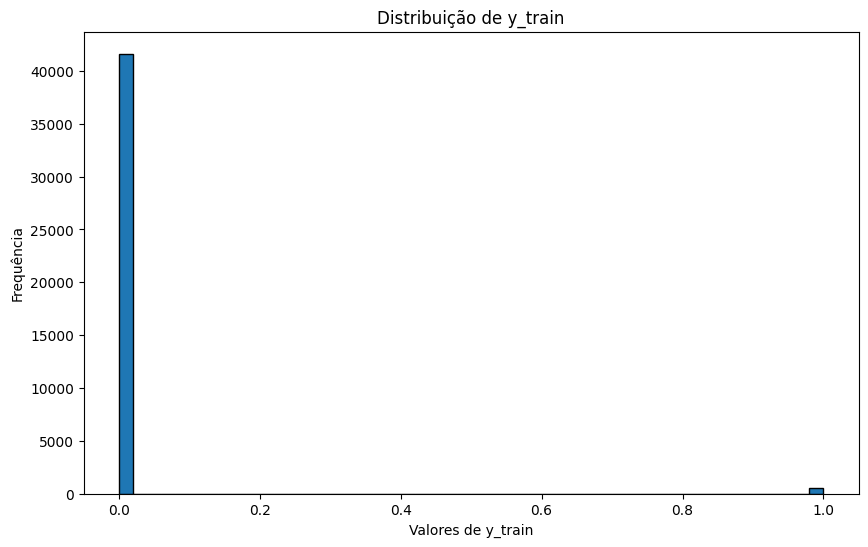

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(y_train, bins=50, edgecolor='black')
plt.title('Distribuição de y_train')
plt.xlabel('Valores de y_train')
plt.ylabel('Frequência')
plt.show()


In [14]:

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Pesos de classe:", class_weights)

unique_labels = np.unique(y)
print("Valores únicos em y:", unique_labels)



Pesos de classe: {0: 0.5062930848125285, 1: 40.22614503816794}
Valores únicos em y: [0 1]


In [15]:

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K


model = Sequential()
model.add(Input(shape=(Xfinal.shape[1], 1)))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [ ]:

history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=64,
    validation_data=(X_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping]
)


Epoch 1/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.7192 - loss: 0.5945 - val_accuracy: 0.7048 - val_loss: 0.5762
Epoch 2/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.7999 - loss: 0.5287 - val_accuracy: 0.8309 - val_loss: 0.4018
Epoch 3/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.7568 - loss: 0.4863 - val_accuracy: 0.8940 - val_loss: 0.3024
Epoch 4/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.7660 - loss: 0.5068 - val_accuracy: 0.8984 - val_loss: 0.3753
Epoch 5/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.8834 - loss: 0.4675 - val_accuracy: 0.7978 - val_loss: 0.3893
Epoch 6/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.7929 - loss: 0.4534 - val_accuracy: 0.9117 - val_loss: 0.3365
Epoch 7/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.8501 - loss: 0.4955 - val_accuracy: 0.9204 - val_loss: 0.2588
Epoch 8/300
659/659 ━━━━━━━━━━━━━━━━━━━━ 38s 58ms/step - accuracy: 0.8729 - loss: 0

In [ ]:
model.save('/content/data_directory/shakeitoff/modelo_960_120.h5')


Modelo salvo como 'modelo_sismico_lunar3.h5'.


In [17]:
from tensorflow.keras.models import load_model
model_path = '/content/data_directory/shakeitoff/modelo_960_120.h5'
model = load_model(model_path)


10
processandoxa.s15.00.mhz.1974-11-17HR00_evid00162.mseed


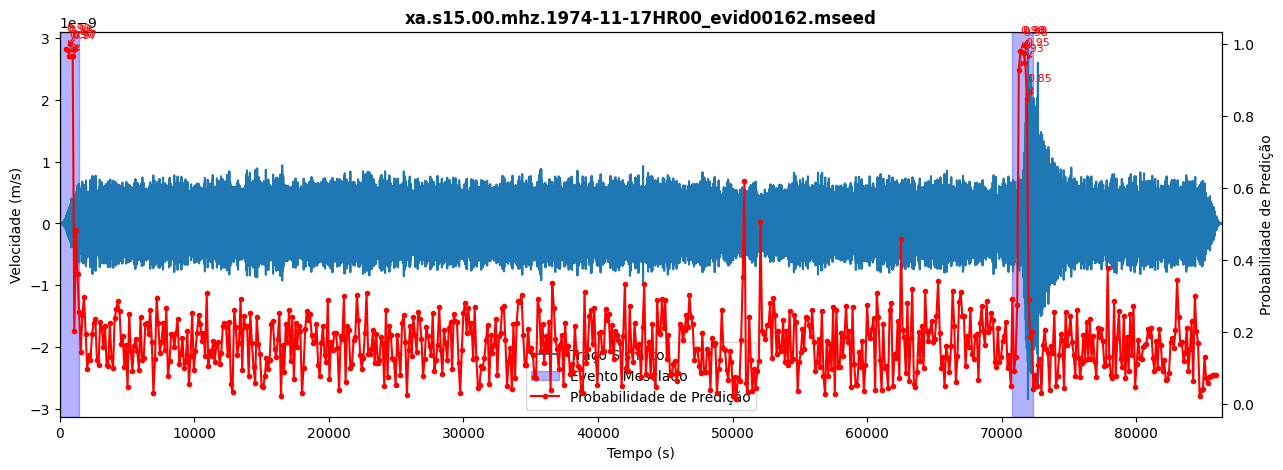

processandoxa.s15.00.mhz.1974-11-21HR00_evid00166.mseed


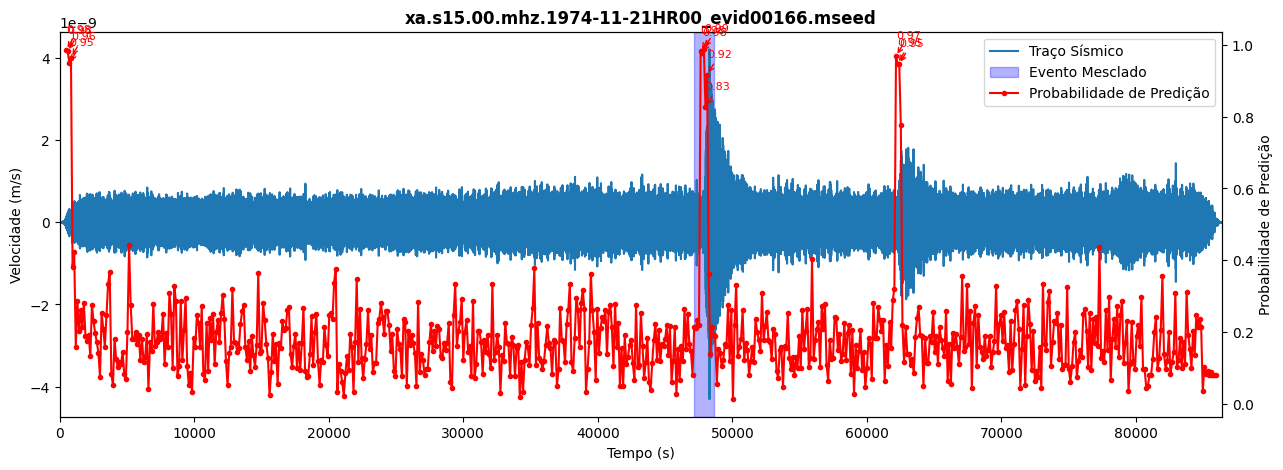

processandoxa.s15.00.mhz.1974-12-15HR00_evid00169.mseed


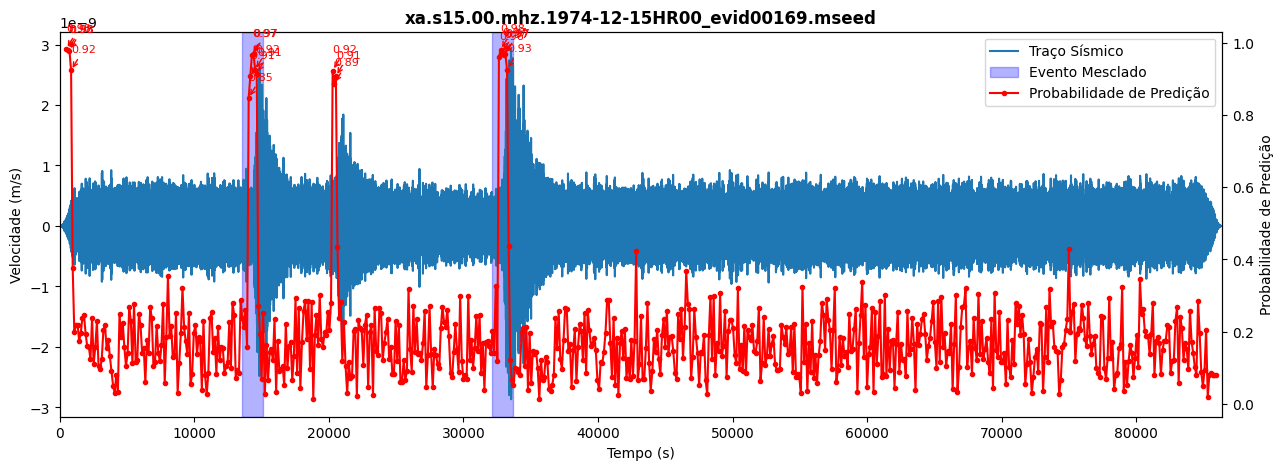

processandoxa.s15.00.mhz.1975-06-22HR00_evid00194.mseed


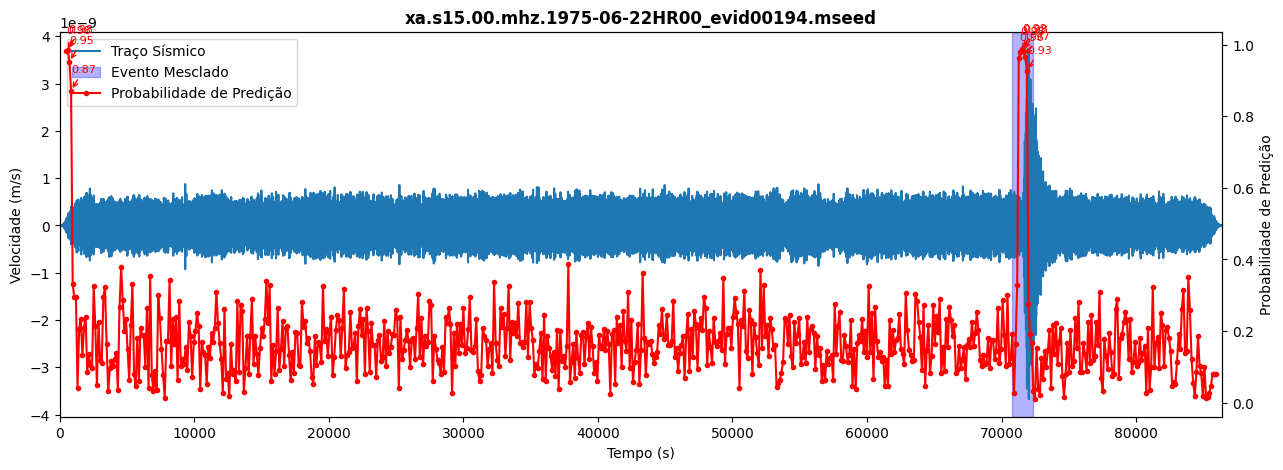

processandoxa.s15.00.mhz.1973-10-27HR00_evid00134.mseed


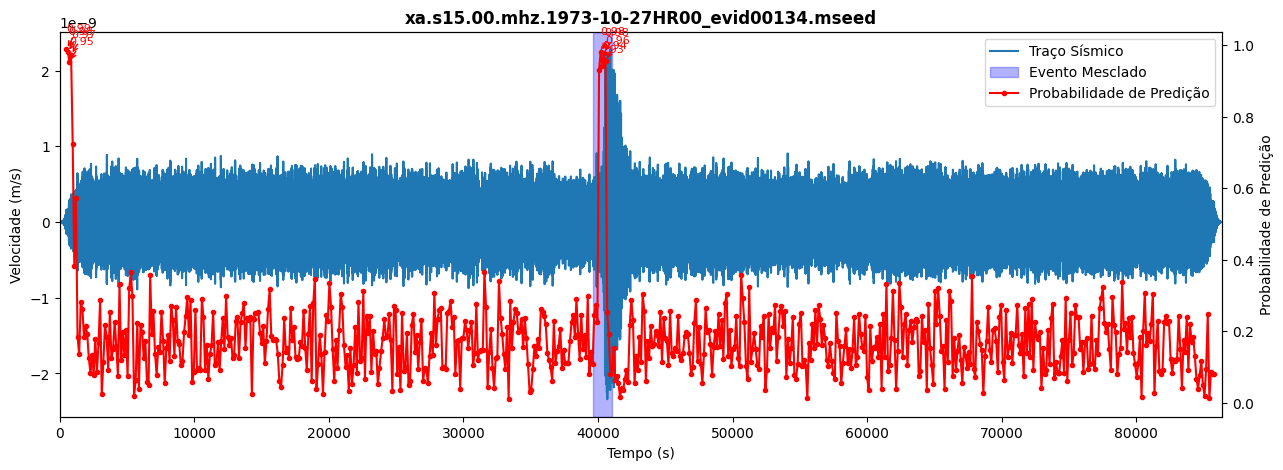

processandoxa.s15.00.mhz.1973-04-04HR00_evid00098.mseed


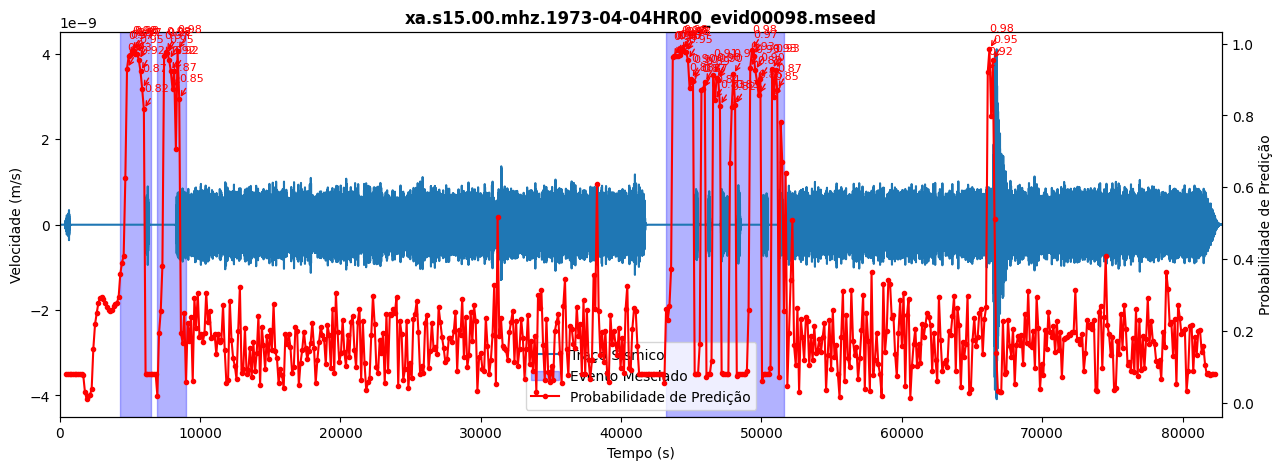

processandoxa.s15.00.mhz.1974-10-19HR00_evid00157.mseed


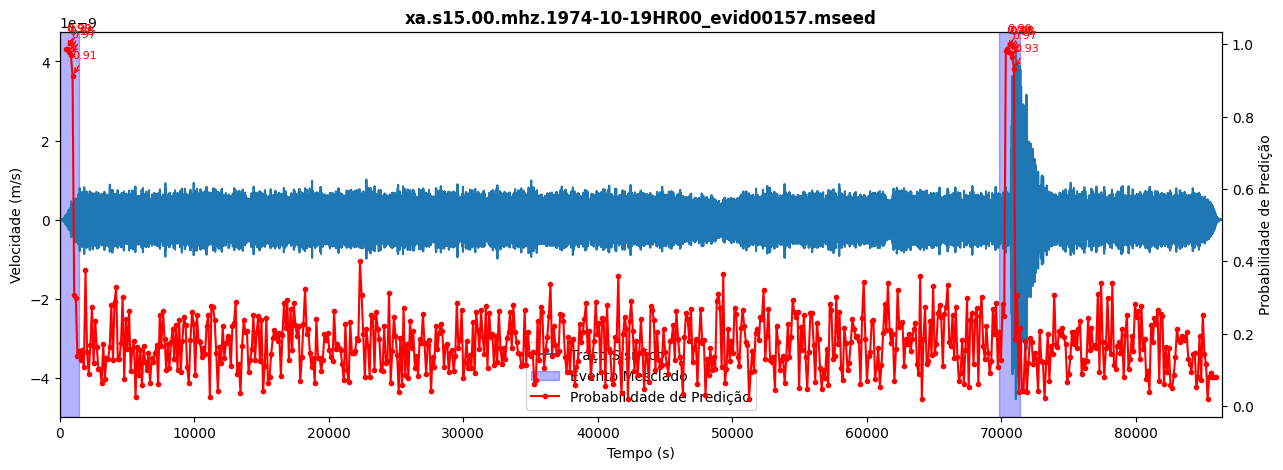

processandoxa.s15.00.mhz.1974-12-15HR00_evid00170.mseed


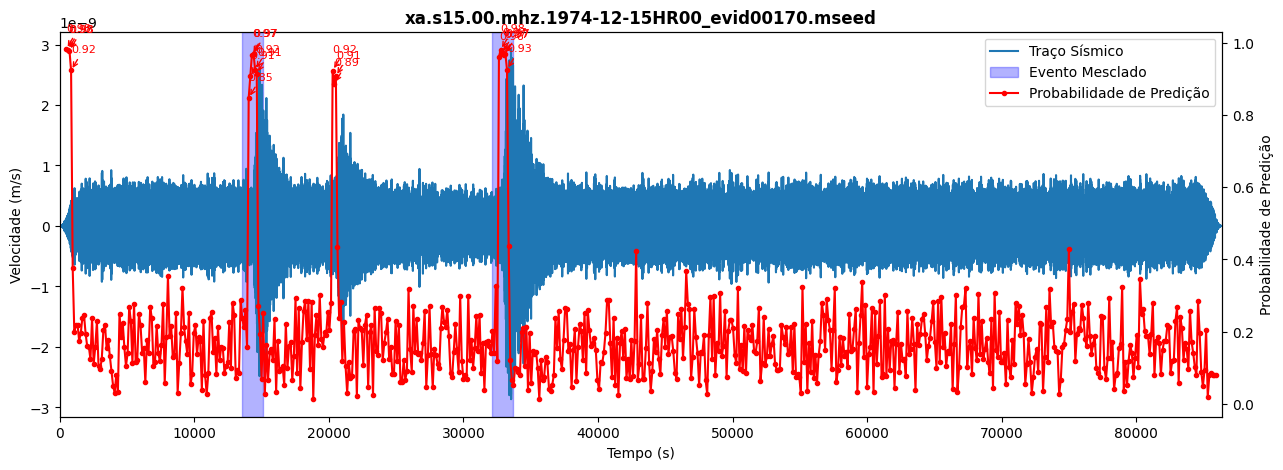

processandoxa.s15.00.mhz.1975-04-12HR00_evid00190.mseed


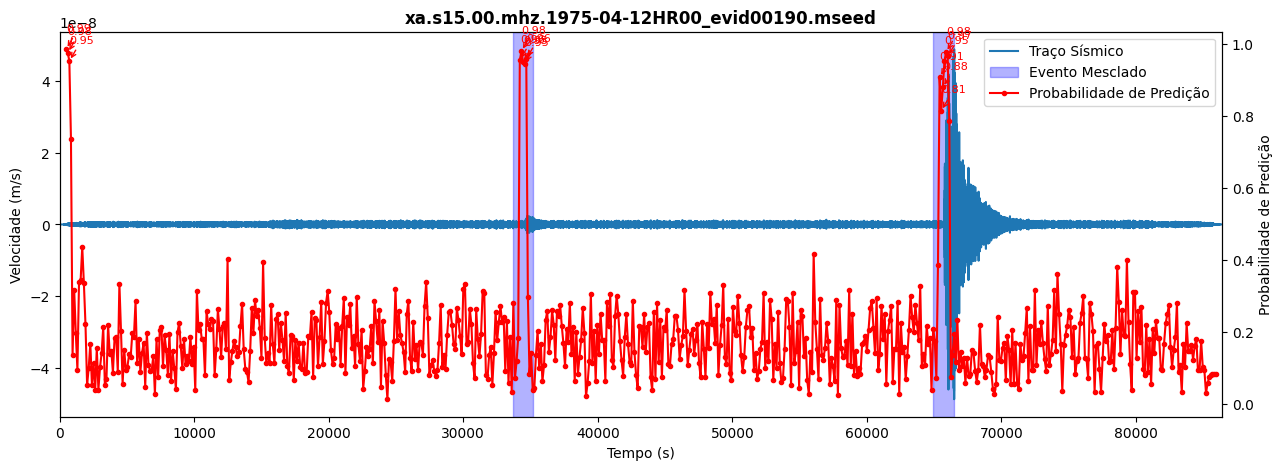

processandoxa.s15.00.mhz.1973-08-10HR00_evid00126.mseed


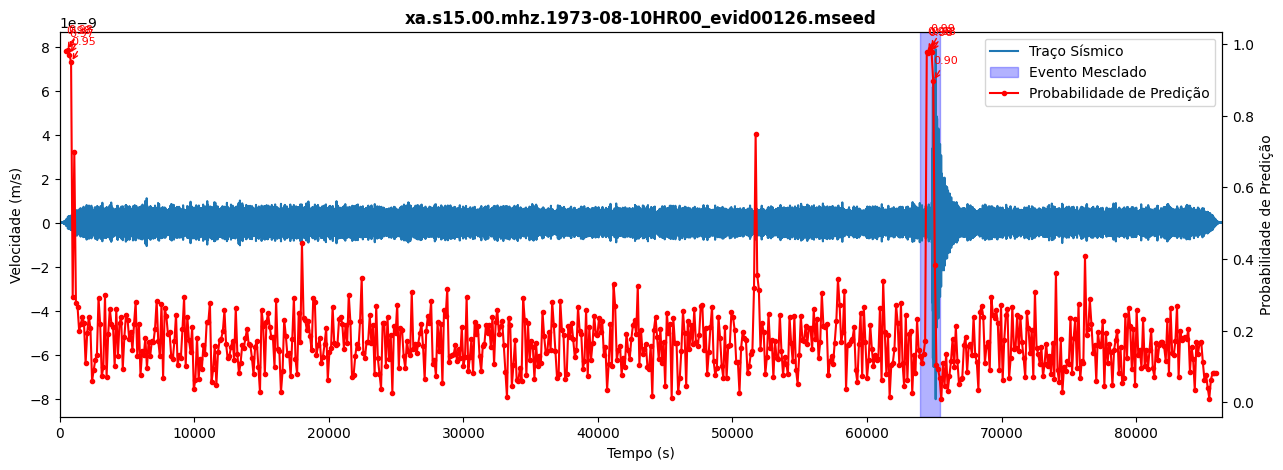

In [19]:
# Definir frequências de filtro e parâmetros da janela

minfreq = 0.6
maxfreq = 1.0
window_size = 960  # seconds
step_size = 120    # seconds

def merge_intervals(intervals, gap=120):
    if not intervals:
        return []

    intervals.sort(key=lambda x: x['start'])
    merged = [intervals[0]]
    for current in intervals[1:]:
        prev = merged[-1]
        if current['start'] - prev['end'] <= gap:
            merged[-1] = {'start': prev['start'], 'end': max(prev['end'], current['end'])}
        else:
            merged.append(current)
    return merged

def plot_seismic_trace(times, data, prediction_times, prediction_probs, merged_events, positive_intervals, test_filename):
    fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))
    ax1.plot(times, data, label='Traço Sísmico')

    for idx, event in enumerate(merged_events):
        start_time, end_time = event['start'], event['end']
        ax1.axvspan(start_time, end_time, color='blue', alpha=0.3, label='Evento Mesclado' if idx==0 else '')

    ax2 = ax1.twinx()
    ax2.plot(prediction_times, prediction_probs, 'r.-', label='Probabilidade de Predição')
    ax2.set_ylabel('Probabilidade de Predição')

    for idx, interval in enumerate(positive_intervals):
        mid_time = (interval['start'] + interval['end']) / 2
        prob = interval['prob']
        ax2.annotate(f'{prob:.2f}', xy=(mid_time, prob), xytext=(mid_time, prob + 0.05),
                     arrowprops=dict(arrowstyle='->', color='red'), fontsize=8, color='red')

    ax1.set_xlim([min(times), max(times)])
    ax1.set_ylabel('Velocidade (m/s)')
    ax1.set_xlabel('Tempo (s)')
    ax1.set_title(f'{test_filename}', fontweight='bold')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2)

    plt.show()


test_directory = os.path.join(basePath, 'data/lunar/test/data/S15_GradeA/')
mseed_files = [f for f in os.listdir(test_directory) if f.endswith('.mseed')]

num_files_to_process = 100

events_list = []

print(len(mseed_files))

for i in range(min(num_files_to_process, len(mseed_files))):

    test_filename = mseed_files[i]
    print('processando' + test_filename)
    mseed_file = os.path.join(test_directory, test_filename)

    try:
        st = read(mseed_file)
        tr = st[0]


        filtered_data = signal_processing(mseed_file=mseed_file)
        trace_start_time = tr.stats.starttime
        df = tr.stats.sampling_rate
        n_samples = len(filtered_data)

        window_samples = int(window_size * df)
        step_samples = int(step_size * df)


        times = np.arange(n_samples) / df

        positive_intervals = []
        prediction_times = []
        prediction_probs = []

        for start in range(0, n_samples - window_samples + 1, step_samples):

            end = start + window_samples
            segment = filtered_data[start:end]

            if len(segment) != window_samples:
                continue

            iqr = np.percentile(segment, 75) - np.percentile(segment, 25)
            if iqr != 0:
                segment = (segment - np.median(segment)) / iqr
            else:
                segment = segment - np.median(segment)

            segment_input = segment.reshape(1, window_samples, 1)

            y_pred_prob = model.predict(segment_input, verbose=0)
            y_pred = (y_pred_prob > 0.8).astype("int32")

            segment_mid_time_sec = (start + end) / 2 / df

            prediction_times.append(segment_mid_time_sec)
            prediction_probs.append(y_pred_prob[0][0])

            if y_pred[0][0] == 1:
                start_time_sec = start / df
                end_time_sec = end / df
                positive_intervals.append({'start': start_time_sec, 'end': end_time_sec, 'prob': y_pred_prob[0][0]})


        intervals_to_merge = [{'start': interval['start'], 'end': interval['end']} for interval in positive_intervals]
        merged_events = merge_intervals(intervals_to_merge, gap=200)

        final_events = []
        for event in merged_events:
            event_start = event['start']
            event_end = event['end']
            count = sum(1 for interval in positive_intervals if interval['start'] >= event_start and interval['end'] <= event_end)
            if count >= 5:
                final_events.append(event)

        start_time_utc = tr.stats.starttime

        for event in final_events:
            event_start_time = event['start']
            event_end_time = event['end']
            event_start_absolute = start_time_utc + event_start_time
            event_end_absolute = start_time_utc + event_end_time

            event_start_absolute_dt = event_start_absolute.datetime
            relative_time = (event_start_absolute_dt.hour * 3600 +
                             event_start_absolute_dt.minute * 60 +
                             event_start_absolute_dt.second +
                             event_start_absolute_dt.microsecond / 1e6)

            events_list.append({
                'filename': test_filename,
                'time_rel(sec)': int(relative_time),
                'time_abs(%Y-%m-%dT%H:%M:%S.%f)': event_start_absolute.isoformat()
            })


        plot_seismic_trace(times, filtered_data, prediction_times, prediction_probs, final_events, positive_intervals, test_filename)

    except Exception as e:
        print(f"Erro ao processar o arquivo {test_filename}: {e}")
        continue

events_df = pd.DataFrame(events_list)
events_df.to_csv('/content/data_directory/shakeitoff/eventos_detectados_s15a_gap_200.csv', index=False)